###### 2MASS0030-1450 has a rotation period of 4.22 hours

In [1]:
%matplotlib inline

In [2]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
from scipy.io import readsav
import imageio
import math

In [3]:
### Starry configuration
np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [38]:
### Filename

filename = "2M0030-1450_calibch1_bin5_ap_opt.sav"
filename[0:11]

'2M0030-1450'

In [9]:
# read in data
M0030_1450 = readsav('2M0030-1450_calibch1_bin5_ap_opt.sav')
time_2M0030_1450 = np.array(M0030_1450['bint'][:,0],dtype='float64')
flux_2M0030_1450 = np.array(M0030_1450['binflux'][:,0],dtype='float64')
peakp_2M0030_1450 = np.array(M0030_1450['peakp'],dtype='float64')
name_2M0030_1450=M0030_1450['targ_name'].decode('utf-8')
# calculate error
fluxerr_2M0030_1450 = np.zeros_like(flux_2M0030_1450) + np.std(flux_2M0030_1450 - np.roll(flux_2M0030_1450, 1))/np.sqrt(2)

In [10]:
## now the fun part! 
## instantiate a map so we can do inference on this dataset
map = starry.Map(ydeg=5, reflected=False)
map.obl = 0
map.inc = 90

In [11]:
## set the data vector (the flux and the covariance matrix)
map.set_data(flux_2M0030_1450, C=fluxerr_2M0030_1450**2)

In [12]:
### Map variables

mu = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
mu[0] = 1 # sets the first entry of mu to 0
mu[1:] = 0 # Sets the rest of the entries in mu to 1
L = np.empty(map.Ny) # returns an empty array with the same dimensions as Ny, which is 4
L[0] = 1e0 # sets the first entry of L to 1e0
L[1:] = 1e-5 # sets the rest of the entries in L to 1e-5
map.set_prior(L=L) #set the prior mean and covariance of the spherical harmonic coefficients

In [13]:
### More map variables

nrot=max(time_2M0030_1450)/4.22 # Calculate the number of rotations
npts = len(time_2M0030_1450) # create an array with the same number of data points as time_r5_degree
theta = np.linspace(0, 360 * nrot, npts) # returns an array that's evenly spaced between 0 and 360(nrot) spaced by npts
# Rotate to an observer inclination
map.inc=90


# Position of the star relative to the planet in the orbital plane
t = np.reshape(time_2M0030_1450, (1, -1))
p = np.vstack((np.cos(2 * np.pi * t), np.sin(2 * np.pi * t), 0 * t))

ci = np.cos(map.inc * np.pi / 180)
si = np.sin(map.inc * np.pi / 180)
R = np.array([[1, 0, 0], [0, ci, -si], [0, si, ci]])
xs, ys, zs = R.dot(p)
kwargs = dict(theta=theta, xs=xs, ys=ys, zs=zs)

In [14]:
%%time
mu, cho_cov = map.solve(**kwargs)

CPU times: user 275 ms, sys: 193 ms, total: 468 ms
Wall time: 4.46 s


In [15]:
a = map.solve(**kwargs)

In [16]:
map.show(colorbar=True, projection="moll",file="2M0030-1450/2M0030-1450_ydeg5.jpg")

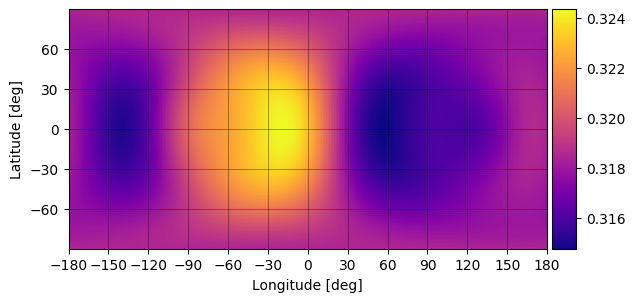

In [17]:
map.show(colorbar=True, projection="rect")

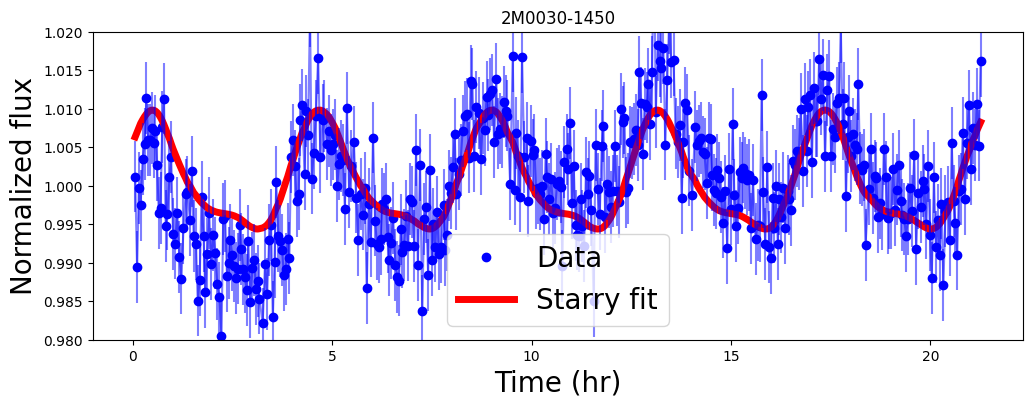

In [18]:
## Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2M0030-1450")
plt.plot(time_2M0030_1450, flux_2M0030_1450,label="Data",linestyle="none",marker="o",color="blue")
plt.ylim(0.98,1.02)
plt.plot(time_2M0030_1450, map.flux(**kwargs),label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(time_2M0030_1450, flux_2M0030_1450, fluxerr_2M0030_1450,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0030_1450_LightCurve.jpg")

In [21]:
### Marginal Likelihood

amp_true = 0.9
inc_true = 90.0
period_true = 4.22
time = time_2M0030_1450

def get_lnlike(inc):
    map.inc = inc
    theta = 360 / period_true * time
    return map.lnlike(theta=theta)

incs = np.linspace(0, 90, 50)
lnlike = np.array([get_lnlike(inc) for inc in incs])

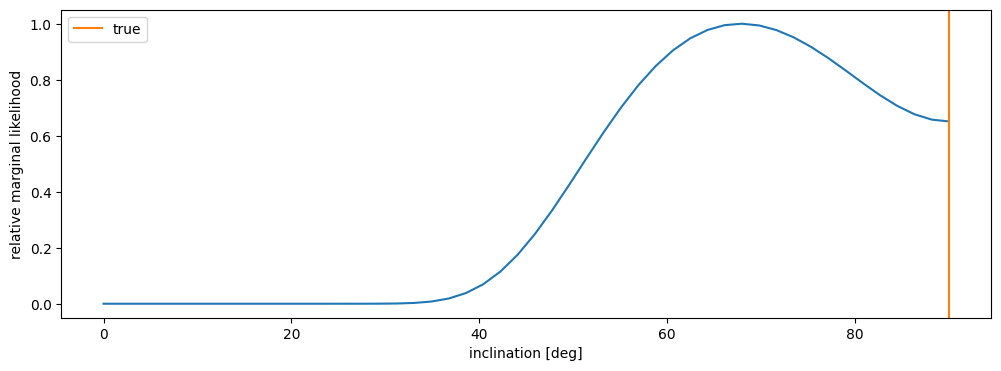

In [22]:
### Plotting Marginal Likelihood

fig, ax = plt.subplots(1, figsize=(12, 4))
like = np.exp(lnlike - lnlike.max())
plt.plot(incs, like)
plt.xlabel(r"inclination [deg]")
plt.ylabel(r"relative marginal likelihood")
plt.axvline(inc_true, color="C1", label="true")
plt.legend()

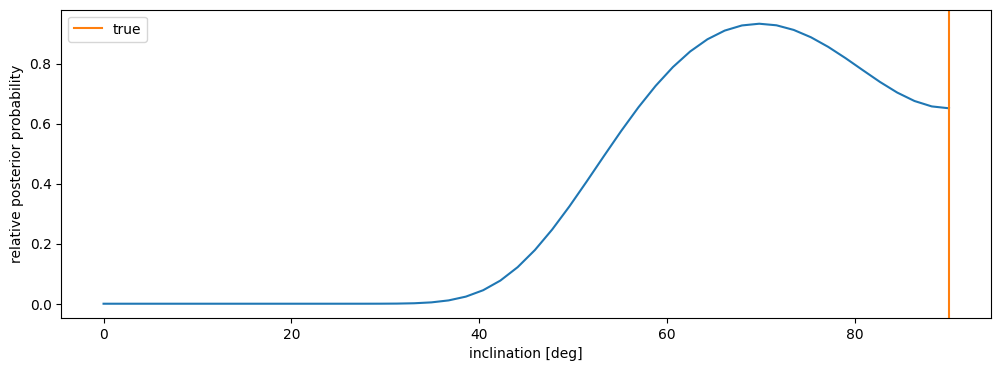

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 4))
posterior = like * np.sin(incs * np.pi / 180)
plt.plot(incs, posterior)
plt.xlabel(r"inclination [deg]")
plt.ylabel(r"relative posterior probability")
plt.axvline(inc_true, color="C1", label="true")
plt.legend()

In [24]:
def get_lnlike(inc, period):
    map.inc = inc
    theta = 360 / period * time
    return map.lnlike(theta=theta)

In [25]:
%%time
incs = np.linspace(0, 90, 500)
periods = np.linspace(1, 5., 500)

lnlike = np.zeros((500, 500))
for i, inc in enumerate(incs):
    for j, period in enumerate(periods):
        lnlike[i, j] = get_lnlike(inc, period)

CPU times: user 53min 24s, sys: 23min 38s, total: 1h 17min 2s
Wall time: 10min 24s


In [26]:
like = np.exp(lnlike - lnlike.max())
posterior = like * np.sin(incs * np.pi / 180).reshape(-1, 1)

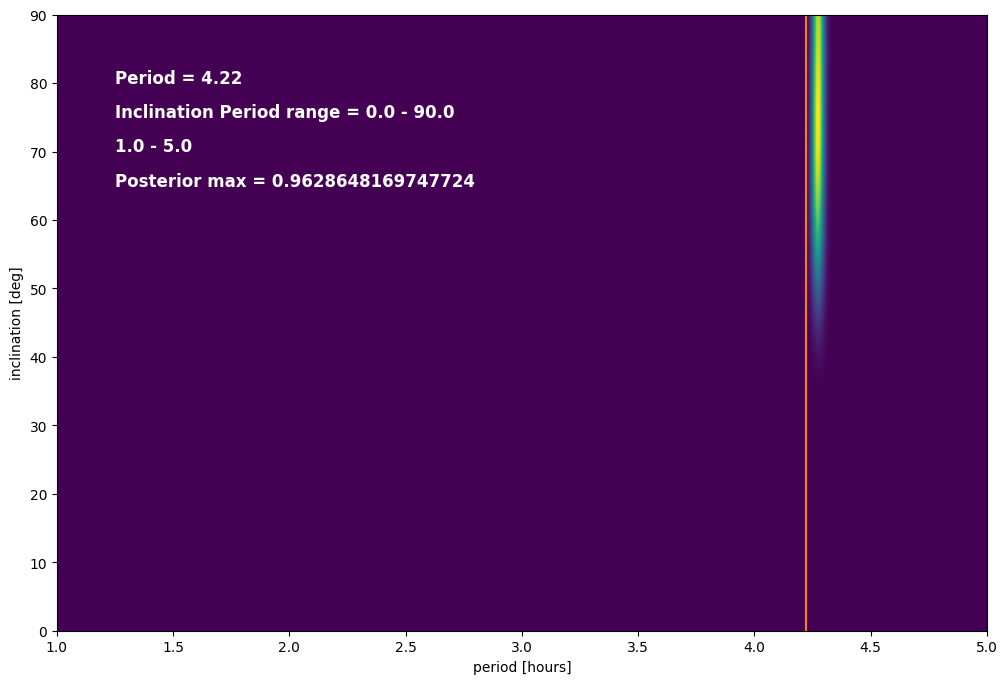

In [27]:
plt.figure(figsize=(12, 8))
plt.imshow(
    posterior,
    extent=(periods[0], periods[-1], incs[0], incs[-1]),
    origin="lower",
    aspect="auto",
)
plt.text(1.25,80,"Period = "+str(period_true),c="white",weight="heavy",size="large")
plt.text(1.25,75,"Inclination Period range = "+str(incs[0])+" - "+str(incs[-1]),c="white",weight="heavy",size="large")
plt.text(1.25,70,str(periods[0])+" - "+str(periods[-1]),c="white",weight="heavy",size="large")
plt.text(1.25,65,"Posterior max = " +str(posterior.max()),c="white",weight="heavy",size="large")
plt.axvline(period_true, color="C1")
plt.axhline(inc_true, color="C1")
plt.xlabel("period [hours]")
plt.ylabel("inclination [deg]");
plt.savefig("2M0030-1450_Likelihood.jpg")

In [42]:
### Function to split rotations then fit them each alone

def RotationSplitter(ydeg,inc_angle,time,flux,sigma,period_true,filename):
    n=1 # Counter for each individual rotation, add 1 when each rotation is fit. Start at first rotation
    new_light_curve = [] # empty list for storing the new light curve from the split rotation
    starry_light_curve_fits = [] # empty list for storing Starry fits
    new_time = [] # empty list for storing the time values for new fitted light curve
    start_index = 0 # have a variable for the index of the start of each rotation
    end_index = 0 # have a variable for the index of the end of each rotation
    end_indices = [] # store values of end indices to mark on plot
    full_rotations = math.floor(time[-1]/period_true) # get the number of full rotations
    sigma=0.001 # Set error
    projection_type = ["moll", "ortho", 'rect'] # array with projection types
    for point in range(len(flux)): # stay within the light curve array
        if n <= full_rotations: # work within number of full rotations
            if time[point] >= period_true*n: # check if the current position in the flux array is within the current rotation number
                if n==1: # check if the current rotation is the first one
                    n+=1 # increase number of rotations to 2
                    end_index=point+1 # get the index for the last point of the current rotation
                    new_light_curve.append([flux[0:end_index]]) # append light curve of current rotation to list
                    new_time.append([time[0:end_index]]) # append the time array of current rotation to list
                    end_indices.append(end_index) # append index of last point in light curve to a list
                elif n!=1:
                    n+=1
                    start_index = end_index # make the starting index for the next rotation
                    end_index += 1 # get the index for the last point of the current rotation
                    new_light_curve.append([flux[start_index:end_index]]) # append light curve of current rotation to list
                    new_time.append([time[start_index:end_index]]) # append the time array of current rotation to list
                    end_indices.append(end_index) # append index of last point in light curve to a list
    rotation_start_points = []
    rotation_start_time = []
    for index in end_indices:
        rotation_start_points.append(flux[index])
        rotation_start_time.append(time[index])
    ### -FITTING EACH INDIVIDUAL ROTATION- ###
    for light_curve in range(len(new_light_curve)):
        map = starry.Map(ydeg=ydeg, reflected=False)
        map.obl = 0
        map.inc = inc_angle
        map.set_data(new_light_curve[light_curve][0], C=0.001** 2)
        ## Other map parameters
        mu = np.empty(map.Ny)
        mu[0] = 1
        mu[1:] = 0
        L = np.empty(map.Ny)
        L[0] = 1e0
        L[1:] = 1e-5
        map.set_prior(L=L)
        nrot=1
        npts = len(new_time[light_curve][0])
        theta = np.linspace(0, 360 * nrot, npts)
        kwargs = dict(theta=theta)
        mu, cho_cov = map.solve(**kwargs)
        starry_light_curve_fits.append([map.flux(**kwargs)])
        for projection in projection_type:
            map.show(colorbar=True,figsize=(10,10),projection=projection, file="2M0030-1450/2M0030-1450_" + projection + "_rotation"+str(light_curve)+str(ydeg) +"ydeg_map.jpg")
    ### -PLOTTING INDIVIDUAL ROTATION FITS- ###
    for i in range(len(new_time)):
        fig, ax = plt.subplots(1,figsize=(12, 4))
        plt.title(filename[0:11] + " ydeg "+str(ydeg) + " Starry fits Rotation " + str(i+1))
        plt.plot(new_time[i][0],starry_light_curve_fits[i][0],linewidth=5,color="red")
        plt.plot
        plt.savefig("2M0030-1450/2M0030_" + projection + "_rotation"+str(light_curve)+str(ydeg) +"ydeg_LightCurve.jpg")
  ### -PLOTTING FULL LIGHT CURVE WITH INDIVIDUAL ROTATION FITS- ###
    fig, ax = plt.subplots(1,figsize=(12, 4))
    plt.title("2M0030-1450 ydeg "+str(ydeg) + " Starry fits")
    plt.plot(rotation_start_time, rotation_start_points, c="orangered")
    plt.plot(time, flux,label="Data",linestyle="none",marker="o",color="blue")
    plt.plot(new_time[0][0], starry_light_curve_fits[0][0],label="Starry fit",linewidth=5,color="red")
    for i in range(len(new_time)):
        plt.plot(new_time[i][0], starry_light_curve_fits[i][0],linewidth=5,color="red")
    plt.legend(prop={'size': 20})
    ax.set_xlabel("Time (days)", fontsize=20)
    ax.set_ylabel("Flux", fontsize=20)
    plt.savefig("2M0030-1450/2M0030_" + projection + "_rotation"+str(light_curve)+str(ydeg) +"ydeg_StarryFits.jpg")

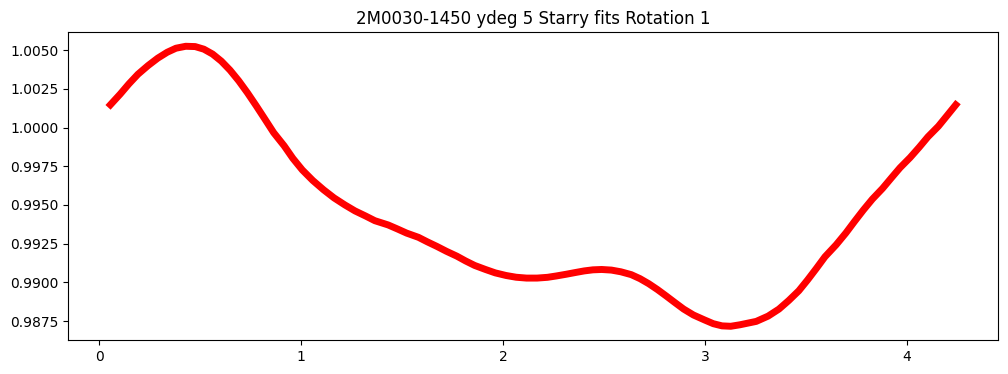

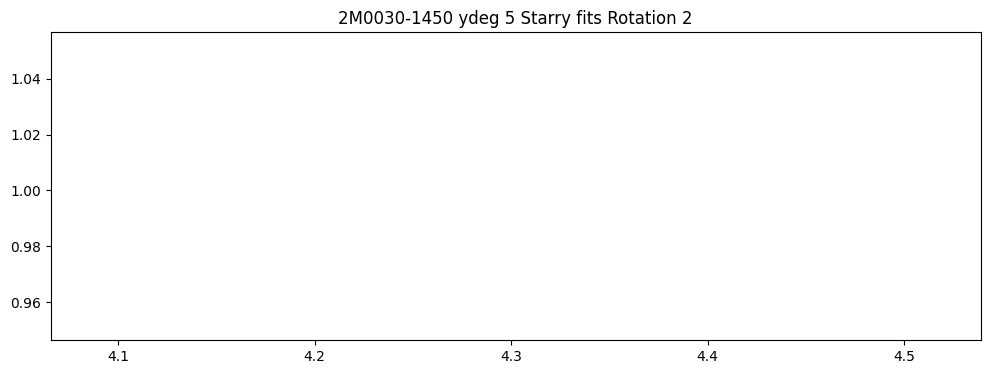

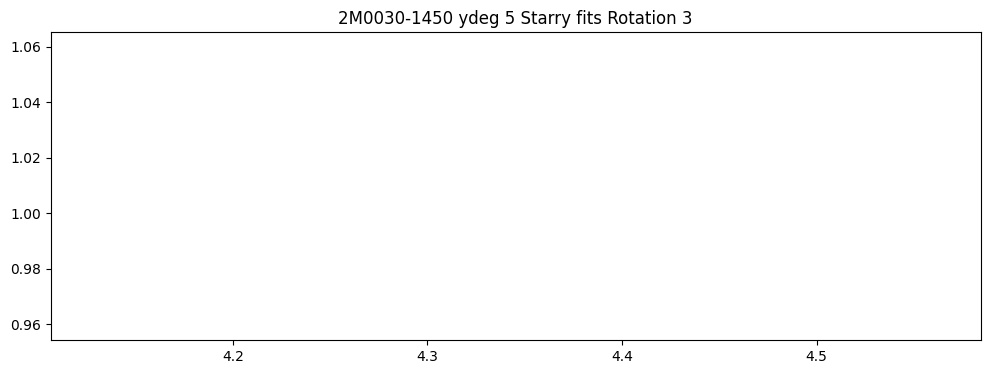

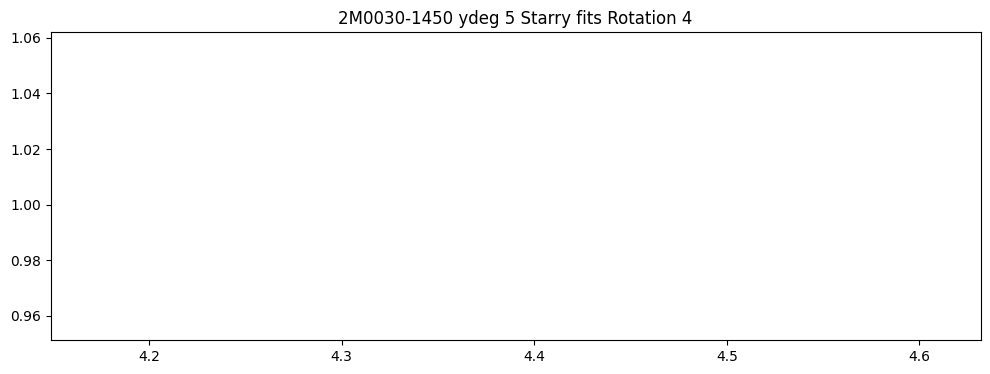

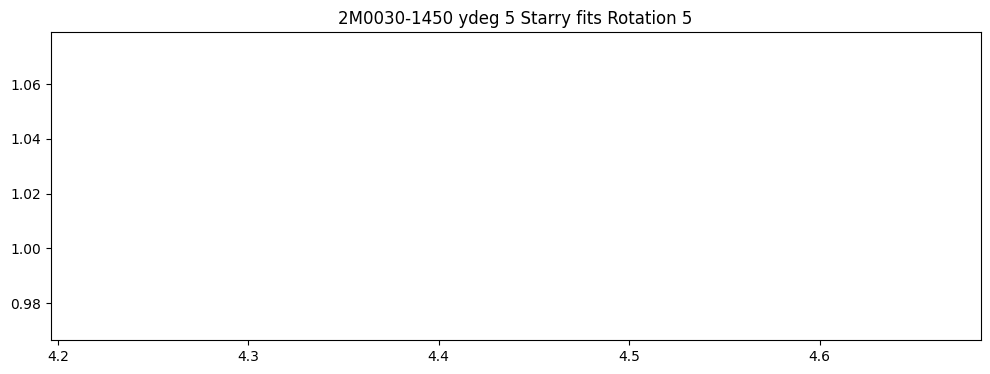

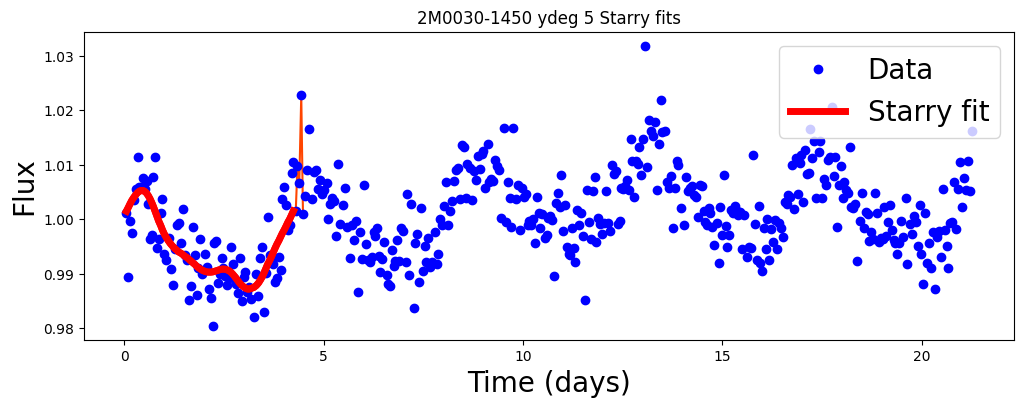

In [43]:
RotationSplitter(5,90,time_2M0030_1450,flux_2M0030_1450,0.01,period_true,filename)

In [ ]:
##### Plotting
fig, ax = plt.subplots(1, figsize=(12, 4))
plt.title("2MASS0030-1450")
plt.plot(timefitted_M0030_1450, flux_2M0030_1450[0:435],label="Data",linestyle="none",marker="o",color="blue")
#plt.ylim(0.98,1.02)
plt.plot(timefitted_2M0030_1450, fluxfitted_2M0030_1450,label="Starry fit",linewidth=5,color="red")
plt.legend(prop={'size': 20})
plt.errorbar(timefitted_2M20030_1450, flux_2M0030_1450[0:435], fluxerr_2M0030_1450,alpha=0.5,color="blue")
ax.set_xlabel("Time (hr)", fontsize=20)
ax.set_ylabel("Normalized flux", fontsize=20)
plt.savefig("2M0030-1450_StarryFitted_Curve_ydeg5.jpg")